# Chapter 14: Deep Computer Vision Using CNN

- Many neurons in the visual cortex have a small local receptive field. They only react to visual stimuli located in a limited region of the visual field
- Some neurons react only to images of horizontal lines, while others react only to lines with different orientations.
- Some neurons have larger receptive fields and they react to more complex patterns that are combinations of the lower-level patterns

![figure14.1](images/figure14.1.png)

# 1. Why not use a deep neural network with fully connected layer?

**Huge number of parameters**
- For small images it is fine. But for larger images, eg: 100x100 pixel image has 10,000 pixels. If the first layer has just 1000 neurons, that will be 10 million connections and its just the first layer
- CNN solve this problem using partially connected layers and weight sharing

# 2. Convolutional Layers

- Convolutional layer is the most important building block of a CNN and why it works so well for images.
- Neurons in the first convolutional layer are not connected to every single pixel in the input image but only to pixels in their receptive fields.
- In the second convolutional layer, each neuron is connected only to neurons located within a small rectangle in the first layer.
- This architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layers

![figure14.2](images/figure14.2.png)

## 2.1 Filters

- A layer full of neurons using the same filter outputs a feature map, which highlights the areas in an image that activate the filter the most.
- During training, the convolutional layer will automatically learn the most useful filters for its task and the layers above will learn to combine them into more complex patterns

![figure14.5](images/figure14.5.png)

## 2.2 Stacking Multiple Feature Maps


- In reality, a convolutional layer has multiple filters and outputs one feature map per filter.
- It has one neuron per pixel in each feature map and all neurons within a given feature map share the same parameters (same weights and bias)
- This reduces the number of parameters in the model.
- Once CNN has learned to recognize a pattern in one location, it can recognize it in any other location.
- In contrast, once DNN learned to recognize a pattern in one location, it can ony recognize in that particular location.
- Neurons in different feature maps use different parameters
- A convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywher in its inputs

Input images are composed of multiple sublayers, RGB channels.

![figure14.6](images/figure14.6.png)

## 2.3 Padding

![figure14.7](images/figure14.7.png)

In [17]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [24]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
def crop(images):
    return images[150:220, 130:250]

The pixel intensity for each color channel is represented as a byte from 0 to 255, so we scale these features by dividing by 255 to get floats ranging from 0 to 1

In [9]:
from sklearn.datasets import load_sample_image
import numpy as np

china = load_sample_image("china.jpg")/255
flower = load_sample_image("flower.jpg")/255

In [12]:
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

Create two 7 x 7 filters

In [15]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

Apply them both to images using SAME padding

In [18]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

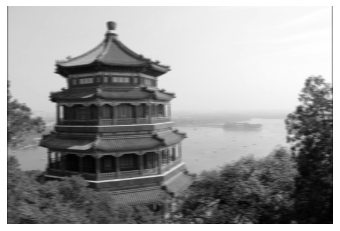

In [19]:
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

Convolutional layers have quite a few hyperparameters - number of filters, height, width, strides and padding type. We can use cross-validation to find the right hyperparameter values

In [23]:
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

## 2.4 Memory

- Convolutional layers require a huge amount of RAM.
- During training, the reverse pass of backpropagation requires all the intermediate values computed during the forward pass.
- If training crashses because of out-of-memory error, we can try reducing the mini-batch size, or reduce the dimensionality using a stride or removing a few layers. Can also try using 16-bit floats instead of 32-bit floats

# 3. Pooling Layers

- The goal is to shrink the input image in order to reduce the computational load, the memory usage and the number of parameters, thereby limiting the risk of overfitting
- Average pooling used to be very popular but people mostly use max pooling layers now as they generally perform better
- Max pooling preserves only the strongest features, getting rid of all the meaningless ones so the next layers get a cleaner signal to work with.
- Max pooling offers stronger translation invariance than average pooling and it requires slightly less computations

![figure14.8](images/figure14.8.png)

- A max pooling layer also introduces some level of invariance to small translations.
- Consider three images going through a max pooling layer with a 2 x 2 kernel and stride 2. 
- Images B and C are the same as Image A but shifted by two pixels to the right.
- The outputs of the max pooling layer from A and B are identical.
- By inserting a max pooing layer every few layers in a CNN, we can get some level of translation invariance at a larger scale
- Max pooling offers a small amount of rotational invariance and a slight scale invariance.
- Such invariance can be useful in cases where the prediction should not depend on these details such as classification tasks.

![figure14.9](images/figure14.9.png)

In [26]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [27]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

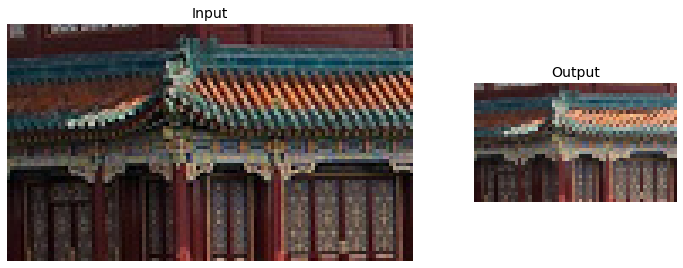

In [29]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

- Max pooling and average pooling can be performed along the depth dimension rather than the spatial dimensions althought it is not common
- This can allow the CNN to learn to be invariant to various features

![figure14.10](images/figure14.10.png)

# 4. CNN Architectures

- CNN Architectures stack a few convolutional layers, then a pooling layer, then another few convolutonal layers ten another pooling layer and so on
- The image gets samller and smaller as it progresses through the network.
- At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers and the infal layer outputs the prediction

![figure14.11](images/figure14.11.png)

- A smaller convolution kernes 3 x 3 usually performs better than bigger kernels 5 x 5

In [30]:
model = keras.models.Sequential([
    # First layer: 64 fairly large filters (7x7) but no stride because input images not very large
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=[28, 28, 1]),
    # Max pooling layer of size 2 (divides each spatial dimension by a factor of 2)
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
    ])

The number of filters grows as we climb up the CNN to the output layer (initially 64, then 128, then 256)
- It makes sense for it to grow since the number of low-level features is often fairly low (eg: small circles, horizontal lines)
- But there are many different ways to combine them into a higher-level features
- It is a common practice to double the number of filters after each pooling layer. 
- This is because since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory or computational load

## 4.1 LeNet-5

Most widely known architecture, created by Yann LeCun in 1998 and has been widely used for handwritten digit recognition

![table14.1](images/table14.1.png)

- **In**: MNIST images are 28 x 28 pixels but they are zero-padded to 32 x 32 pixels and are normalized before beign fed to the network. The rest of network does not use padding
- **S2**: Each neuron computes the mean of its inputs then multiplies the result by a learnable coefficient and adds a learnable bias term then finally apply activation function
- **C3**: C3 maps are connected to neurons in only three or four S2 maps.
- **Out**: Instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidean distance between its input vector and weight vector.

## 4.2 AlexNet

Won the 2012 ImageNet challenge by a large margin. Similar to LeNet-5 but much larger and deeper. Its the first to stack convolutional layers directly on top of one another instead of stacking a pooling layer on top of each convolutional layer

![table14.2](images/table14.2.png)

To reduce overfitting, the authors used two regularization techniques
- Dropout with 50% dropout rate during training
- Data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, change lighting conditions

**Data Augmentation**
- Artificially increases the size of the training set by generating many realistic variants of each training instance.
- Reduces overfitting
- Adding white noise will not help as the modifications should be learnable.
- By shifting, rotating, it forces the model to be more tolerant to variations in the position, orientation and size of the objects in the pictures.

![figure14.12](images/figure14.12.png)

## 4.3 GoogLeNet

Has 10 times fewer parameters than AlexNet

![figure14.14](images/figure14.14.png)

## 4.4 VGGNet

- Used only 3x3 filters but many

## 4.5 ResNet

- Uses skip connections

## 4.6 Xception

- Variant of GoogLeNet architecture
- Stands for Extreme Inception